c:\Users\Owner\OneDrive\Desktop\Study\MDS\Year 2\ProjectBasedLearning\Project1\chatbot\venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Owner\OneDrive\Desktop\Study\MDS\Year 2\ProjectBasedLearning\Project1\chatbot\venv\Lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
c:\Users\Owner\OneDrive\Desktop\Study\MDS\Year 2\ProjectBasedLearning\Project1\chatbot\venv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best parameter value(s): {'alpha': 0.07}
Training - Accuracy Score: 0.9824561403508771
Validating - Accuracy Score: 0.8275862068965517


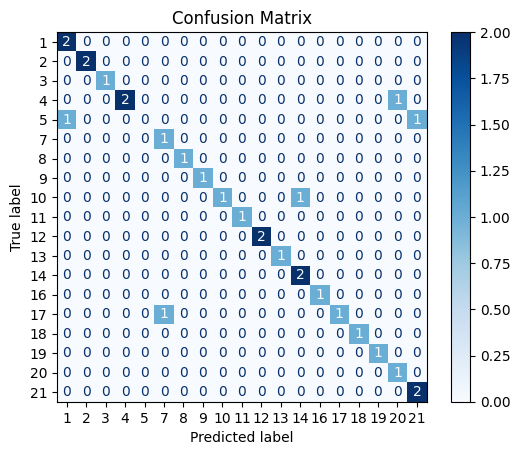

In [166]:
import json
from sklearn import metrics
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
import spacy
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
with open("intent.json") as f:
    intents = json.load(f)
nlp = spacy.load('en_core_web_sm', disable=['tagger', 'parser', 'attribute_ruler', 'ner'])
nlp.pipe_names
inputs = []
targets = []
classes = set()
intent_doc = dict()

def tokenizer(doc):
    # Tokenize data + lemmatation + remove punctuation + extra spaces
    return [t.lemma_ for t in nlp(doc) if not t.is_punct and not t.is_space ]
    
for item in intents['intents']:
    if item["intent"] not in classes:
        classes.add(item["intent"])
    if item["intent"] not in intent_doc:
        intent_doc[item["intent"]] = []
    for text in item["text"]: 
        inputs.append(text)
        targets.append(item["intent"])
    for response in item["responses"]:
        intent_doc[item["intent"]].append(response)

target_names = set(targets)

# # Plot data distribution
# bins, counts = np.unique(targets, return_counts=True)
# freq_series = pd.Series(counts/len(inputs))
# plt.figure(figsize=(12, 8))
# ax = freq_series.plot(kind='bar')
# ax.set_xticklabels(bins, rotation=0)
# plt.show()

le = LabelEncoder()
encoded_targets = le.fit_transform(targets)
label_mapping = {str(k): int(v) for k, v in zip(le.classes_, le.transform(le.classes_))}
vectorizer = CountVectorizer(tokenizer=tokenizer, lowercase=True, ngram_range=(1,2))
vectorized_features = vectorizer.fit_transform(inputs)

x_train, x_test, y_train, y_test = train_test_split(vectorized_features, encoded_targets, train_size=0.8, random_state=1) 

# Naive Bayes Training: 0.98, Validating: 0.82 
params = {'alpha': [0.01, 0.5, 0.07, 0.1, 0.5, 1.0, 10.0,],}
multinomial_nb_grid = model_selection.GridSearchCV(MultinomialNB(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
multinomial_nb_grid.fit(x_train, y_train)
print('Best parameter value(s): {}'.format(multinomial_nb_grid.best_params_))
best_nb_classifier = multinomial_nb_grid.best_estimator_


# # Random Forest Classifier Training: 1.0, Validating: 0.72 
# params = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
# random_forest_grid = model_selection.GridSearchCV(RandomForestClassifier(random_state=1), param_grid=params, n_jobs=-1, cv=5, verbose=5)
# random_forest_grid.fit(x_train, y_train)
# print('Best parameter value(s): {}'.format(random_forest_grid.best_params_))
# best_rf_classifier = random_forest_grid.best_estimator_

# # Define Decision Tree Classifier Training: 1.0, Validating: 0.62 
# params = {'max_depth': [5, 10, 20, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
# decision_tree_grid = model_selection.GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid=params, n_jobs=-1, cv=5, verbose=5)
# decision_tree_grid.fit(x_train, y_train)
# print('Best parameter value(s): {}'.format(decision_tree_grid.best_params_))
# best_dt_classifier = decision_tree_grid.best_estimator_

train_preds = best_nb_classifier.predict(x_train)
print('Training - Accuracy Score: {}'.format(metrics.accuracy_score(y_train, train_preds)))

val_preds = best_nb_classifier.predict(x_test)
print('Validating - Accuracy Score: {}'.format(metrics.accuracy_score(y_test, val_preds)))

# conf_matrix = confusion_matrix(y_test, val_preds)
# display = ConfusionMatrixDisplay(conf_matrix, display_labels=le.classes_)
# display.plot(cmap='Blues')
# plt.title("Confusion Matrix")
# plt.show()

# Compute and display confusion matrix
conf_matrix = confusion_matrix(y_test, val_preds, labels=np.unique(y_test))
display = ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(y_test))
display.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


